In [4]:
# Cell 2: Import Libraries
import pandas as pd
import nltk
import gensim
import gensim.corpora as corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel, TfidfModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import os
from pprint import pprint
import matplotlib.pyplot as plt
import random
import time
import numpy as np

# For BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP # BERTopic uses UMAP
from hdbscan import HDBSCAN # BERTopic uses HDBSCAN

# For LDA Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# For BERTopic manual similarity plot if needed
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

import plotly.io as pio
pio.renderers.default = "colab"

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

print("Libraries imported and NLTK resources checked/downloaded.")

Libraries imported and NLTK resources checked/downloaded.


In [5]:
df = pd.read_csv('arXiv_scientific dataset.csv')
df.info()
print("\nMissing summaries before drop:", df['summary'].isnull().sum())
df.dropna(subset=['summary'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Shape after dropping missing summaries: {df.shape}")
print("\nFirst 5 rows:")
pprint(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136238 entries, 0 to 136237
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  136238 non-null  object
 1   title               136238 non-null  object
 2   category            136238 non-null  object
 3   category_code       136238 non-null  object
 4   published_date      136238 non-null  object
 5   updated_date        136238 non-null  object
 6   authors             136238 non-null  object
 7   first_author        136238 non-null  object
 8   summary             136238 non-null  object
 9   summary_word_count  136238 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 10.4+ MB

Missing summaries before drop: 0
Shape after dropping missing summaries: (136238, 10)

First 5 rows:
             id                                              title  \
0  cs-9308101v1                               Dynamic Backtracking   
1  cs-93

In [6]:
# Cell 4: Select Text & Subsample

documents_full = df['summary'].tolist()
print(f"Total number of documents (summaries) extracted: {len(documents_full)}")

### YOU NEED TO DECIDE/ADJUST ###
SAMPLE_SIZE = 50000  # Using 50k as per our previous discussions
# For quicker testing, you can reduce this to 5000 or 10000
# For full run on 136k, set use_sample = False (will be very slow)
USE_SAMPLE = False

if USE_SAMPLE and len(documents_full) > SAMPLE_SIZE:
    random.seed(42)
    documents_to_process = random.sample(documents_full, SAMPLE_SIZE)
    print(f"Using a sample of {SAMPLE_SIZE} documents for processing.")
else:
    documents_to_process = documents_full
    print(f"Using all {len(documents_to_process)} documents for processing.")

print(f"Number of documents selected for processing: {len(documents_to_process)}")

Total number of documents (summaries) extracted: 136238
Using all 136238 documents for processing.
Number of documents selected for processing: 136238


In [18]:
# Cell 5: LDA - Preprocessing Function & Resources

stop_words_nltk = stopwords.words('english')
### YOU NEED TO DECIDE/ADJUST ### (Refine this list based on topic outputs)
custom_stopwords_lda = [
    'paper', 'study', 'research', 'results', 'approach', 'method', 'propose', 'show', 'model', 'work', 'task', 'based',
    'demonstrate', 'present', 'introduce', 'discuss', 'explore', 'investigate', 'use', 'using', 'also', 'however',
    'analyze', 'evaluate', 'consider', 'provide', 'develop', 'aim', 'focus', 'via', 'therefore', 'thu', 'thus',
    'et', 'al', 'fig', 'figure', 'table', 'section', 'chapter', 'abstract', 'introduction', 'conclusion',
    'acknowledgement', 'reference', 'appendix', 'preprint', 'arxiv', 'datum', 'data', 'algorithm', 'network',
    'problem', 'system', 'time', 'value', 'state', 'art', 'different', 'large', 'well', 'set', 'number',
    'performance', 'function', 'sample', 'result', 'approach', 'framework', 'information', 'process'
]
stop_words_lda = list(set(stop_words_nltk + custom_stopwords_lda))
lemmatizer_lda = WordNetLemmatizer()

def preprocess_text_lda(text):
    tokens = []
    for token in gensim.utils.simple_preprocess(str(text), deacc=True):
        if token not in stop_words_lda and len(token) > 2:
            tokens.append(lemmatizer_lda.lemmatize(token, pos='v')) # Lemmatize as verbs
    return tokens

print("LDA preprocessing function defined with custom stopwords.")
print(f"Total LDA stopwords: {len(stop_words_lda)}")

LDA preprocessing function defined with custom stopwords.
Total LDA stopwords: 268


In [19]:
# Cell 6: LDA - Apply Preprocessing & Create Phrases

print("Starting LDA text preprocessing...")
start_time_lda_prep = time.time()
processed_docs_lda_tokens = [preprocess_text_lda(doc) for doc in documents_to_process]

# Phrase modeling (Bigrams/Trigrams)
bigram_phrases_lda = gensim.models.Phrases(processed_docs_lda_tokens, min_count=10, threshold=50) # Adjust min_count/threshold
trigram_phrases_lda = gensim.models.Phrases(bigram_phrases_lda[processed_docs_lda_tokens], threshold=50)
bigram_mod_lda = gensim.models.phrases.Phraser(bigram_phrases_lda)
trigram_mod_lda = gensim.models.phrases.Phraser(trigram_phrases_lda)
processed_docs_lda_phrased = [trigram_mod_lda[bigram_mod_lda[doc]] for doc in processed_docs_lda_tokens]
end_time_lda_prep = time.time()
print(f"LDA text preprocessing & phrasing complete. Took: {(end_time_lda_prep - start_time_lda_prep):.2f} seconds.")
print("\nExample processed LDA document (phrased):")
pprint(processed_docs_lda_phrased[0][:20]) # Show first 20 tokens

Starting LDA text preprocessing...
LDA text preprocessing & phrasing complete. Took: 172.61 seconds.

Example processed LDA document (phrased):
['occasional',
 'need',
 'return',
 'shallow',
 'point',
 'search',
 'tree',
 'exist',
 'backtrack',
 'methods',
 'sometimes',
 'erase',
 'meaningful',
 'progress',
 'toward',
 'solve',
 'search',
 'backtrack',
 'point',
 'move']


In [20]:
# Cell 7: LDA - Create Dictionary and Corpus (FOR FULL DATASET)

print("Creating LDA Dictionary and Corpus (FULL DATASET)...")
id2word_lda = corpora.Dictionary(processed_docs_lda_phrased) # Assuming processed_docs_lda_phrased is from ALL docs
print(f"Initial LDA dictionary size (full dataset): {len(id2word_lda)}")

### YOU NEED TO DECIDE/ADJUST for FULL DATASET ###
# Consider slightly increasing no_below for a larger dataset
NO_BELOW_FULL = 25  # e.g., word must appear in at least 25 docs
NO_ABOVE_FULL = 0.4 # Keep as is, or maybe slightly lower (0.35) if common words are an issue
KEEP_N_FULL = 100000 # Start with a generous number, can be adjusted

# First, see how many words pass no_below and no_above
id2word_lda_temp = corpora.Dictionary(processed_docs_lda_phrased) # Create a temporary one for checking
id2word_lda_temp.filter_extremes(no_below=NO_BELOW_FULL, no_above=NO_ABOVE_FULL, keep_n=None)
print(f"Vocab size after no_below={NO_BELOW_FULL} & no_above={NO_ABOVE_FULL} (no keep_n limit): {len(id2word_lda_temp)}")
del id2word_lda_temp # Free up memory

# Now apply the final filter including keep_n
id2word_lda.filter_extremes(no_below=NO_BELOW_FULL, no_above=NO_ABOVE_FULL, keep_n=KEEP_N_FULL)
print(f"Final filtered LDA dictionary size (full dataset): {len(id2word_lda)}")

corpus_lda = [id2word_lda.doc2bow(text) for text in processed_docs_lda_phrased]
print(f"LDA Corpus created (BoW format). Number of documents: {len(corpus_lda)}")
corpus_to_use_lda = corpus_lda

Creating LDA Dictionary and Corpus (FULL DATASET)...
Initial LDA dictionary size (full dataset): 121638
Vocab size after no_below=25 & no_above=0.4 (no keep_n limit): 12721
Final filtered LDA dictionary size (full dataset): 12721
LDA Corpus created (BoW format). Number of documents: 136238


Starting LDA K-finding loop (K from 4 to 30, step 2)...
Training LDA for K=4 (1/14)...
  Coherence for K=4: 0.3873
Training LDA for K=6 (2/14)...
  Coherence for K=6: 0.3766
Training LDA for K=8 (3/14)...
  Coherence for K=8: 0.4235
Training LDA for K=10 (4/14)...
  Coherence for K=10: 0.4179
Training LDA for K=12 (5/14)...
  Coherence for K=12: 0.4525
Training LDA for K=14 (6/14)...
  Coherence for K=14: 0.4362
Training LDA for K=16 (7/14)...
  Coherence for K=16: 0.4555
Training LDA for K=18 (8/14)...
  Coherence for K=18: 0.4471
Training LDA for K=20 (9/14)...
  Coherence for K=20: 0.4431
Training LDA for K=22 (10/14)...
  Coherence for K=22: 0.4456
Training LDA for K=24 (11/14)...
  Coherence for K=24: 0.4576
Training LDA for K=26 (12/14)...
  Coherence for K=26: 0.4588
Training LDA for K=28 (13/14)...
  Coherence for K=28: 0.4704
Training LDA for K=30 (14/14)...
  Coherence for K=30: 0.4625
LDA K-finding loop complete. Took: 1455.12 seconds.


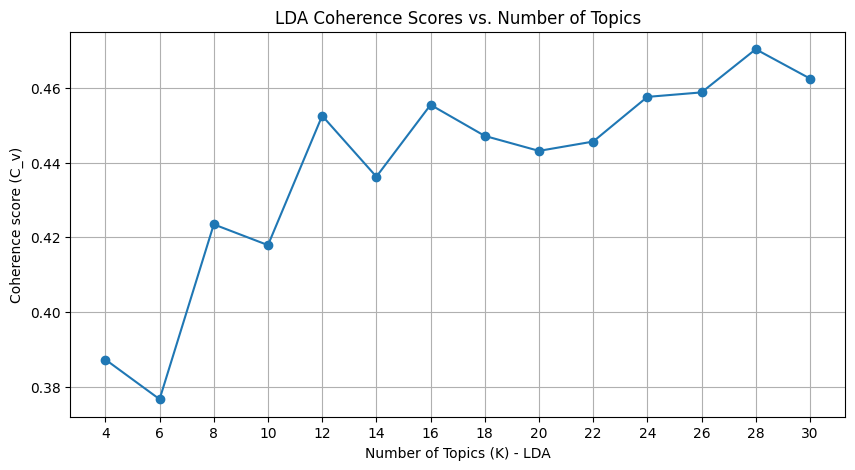


Optimal K for LDA: 28 with C_v Coherence: 0.4704
Top words for optimal LDA model:
[(27,
  '0.032*"question" + 0.031*"reason" + 0.023*"knowledge" + 0.021*"answer" + '
  '0.013*"generate" + 0.013*"question_answer" + 0.012*"query" + 0.011*"model" '
  '+ 0.009*"language" + 0.009*"retrieval"'),
 (26,
  '0.077*"target" + 0.055*"domain" + 0.052*"source" + 0.018*"alignment" + '
  '0.015*"domains" + 0.015*"feature" + 0.012*"domain_adaptation" + '
  '0.010*"speech" + 0.009*"propose" + 0.008*"transfer"'),
 (25,
  '0.035*"train" + 0.032*"task" + 0.026*"domain" + 0.014*"transfer" + '
  '0.012*"shoot" + 0.012*"model" + 0.012*"meta" + 0.011*"new" + '
  '0.011*"datasets" + 0.010*"specific"'),
 (24,
  '0.027*"image" + 0.027*"segmentation" + 0.020*"train" + 0.011*"methods" + '
  '0.011*"propose" + 0.010*"feature" + 0.009*"semantic" + 0.009*"achieve" + '
  '0.008*"datasets" + 0.007*"two"'),
 (23,
  '0.036*"model" + 0.028*"language" + 0.027*"train" + 0.014*"sentence" + '
  '0.013*"text" + 0.013*"translat

In [21]:
# Cell 8: LDA - K-Finding Loop (Coherence)

def compute_coherence_values_lda(corpus, dictionary, texts, k_start, k_stop, k_step, passes=10):
    coherence_values = []
    model_list = []
    k_values = list(range(k_start, k_stop, k_step))
    for k_idx, k in enumerate(k_values):
        print(f"Training LDA for K={k} ({k_idx+1}/{len(k_values)})...")
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, random_state=100,
                             chunksize=1000, passes=passes, workers=os.cpu_count()-1 if os.cpu_count()>1 else 1,
                             alpha='asymmetric', eta='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_val = coherencemodel.get_coherence()
        coherence_values.append(coherence_val)
        print(f"  Coherence for K={k}: {coherence_val:.4f}")
    return model_list, coherence_values, k_values

### YOU NEED TO DECIDE/ADJUST ###
K_START_VAL_LDA = 4
K_STOP_VAL_LDA = 31 # e.g., test up to K=30
K_STEP_VAL_LDA = 2
LDA_PASSES_K_SEARCH = 10 # Fewer passes for K-search speed

print(f"Starting LDA K-finding loop (K from {K_START_VAL_LDA} to {K_STOP_VAL_LDA-1}, step {K_STEP_VAL_LDA})...")
start_time_lda_k_find = time.time()
lda_models_k_search, coherence_scores_lda, k_values_lda = compute_coherence_values_lda(
    corpus=corpus_to_use_lda, dictionary=id2word_lda, texts=processed_docs_lda_phrased,
    k_start=K_START_VAL_LDA, k_stop=K_STOP_VAL_LDA, k_step=K_STEP_VAL_LDA, passes=LDA_PASSES_K_SEARCH
)
end_time_lda_k_find = time.time()
print(f"LDA K-finding loop complete. Took: {(end_time_lda_k_find - start_time_lda_k_find):.2f} seconds.")

# Plot coherence
plt.figure(figsize=(10,5))
plt.plot(k_values_lda, coherence_scores_lda, marker='o')
plt.xticks(k_values_lda)
plt.xlabel("Number of Topics (K) - LDA")
plt.ylabel("Coherence score (C_v)")
plt.title("LDA Coherence Scores vs. Number of Topics")
plt.grid(True)
plt.show()

if coherence_scores_lda:
    optimal_k_lda_index = np.argmax(coherence_scores_lda) # Use argmax instead of .index for numpy arrays
    optimal_k_lda = k_values_lda[optimal_k_lda_index]
    optimal_lda_model = lda_models_k_search[optimal_k_lda_index]
    highest_lda_coherence = coherence_scores_lda[optimal_k_lda_index]
    print(f"\nOptimal K for LDA: {optimal_k_lda} with C_v Coherence: {highest_lda_coherence:.4f}")
    print("Top words for optimal LDA model:")
    pprint(optimal_lda_model.print_topics(num_words=10))
else:
    print("LDA K-finding did not produce results.")
    optimal_lda_model = None # Ensure it's defined

In [22]:
# Cell: Save LDA Model and Components

import os
import pickle # For saving the corpus if it's just a list of lists

# --- Define file paths for saving ---
MODEL_DIR_LDA = "lda_model_arxiv_cs" # Directory to store LDA related files
if not os.path.exists(MODEL_DIR_LDA):
    os.makedirs(MODEL_DIR_LDA)
    print(f"Directory '{MODEL_DIR_LDA}' created.")

LDA_MODEL_FILE = os.path.join(MODEL_DIR_LDA, "lda_optimal_k28.gensim")
DICTIONARY_FILE_LDA = os.path.join(MODEL_DIR_LDA, "id2word_lda.gensimdictionary")
CORPUS_FILE_LDA = os.path.join(MODEL_DIR_LDA, "corpus_lda.mm") # Using Matrix Market format for corpus
# If you also want to save the tokenized documents (processed_docs_lda_phrased)
TOKENIZED_DOCS_LDA_FILE = os.path.join(MODEL_DIR_LDA, "processed_docs_lda_phrased.pkl")


# --- Save the LDA Model ---
if 'optimal_lda_model' in locals() and optimal_lda_model is not None:
    try:
        optimal_lda_model.save(LDA_MODEL_FILE)
        print(f"LDA model saved to: {LDA_MODEL_FILE}")
    except Exception as e:
        print(f"Error saving LDA model: {e}")
else:
    print("optimal_lda_model not found, skipping model save.")

# --- Save the Dictionary ---
if 'id2word_lda' in locals() and id2word_lda is not None:
    try:
        id2word_lda.save(DICTIONARY_FILE_LDA)
        print(f"LDA Dictionary saved to: {DICTIONARY_FILE_LDA}")
    except Exception as e:
        print(f"Error saving LDA dictionary: {e}")
else:
    print("id2word_lda not found, skipping dictionary save.")

# --- Save the Corpus (using Gensim's Matrix Market format) ---
if 'corpus_to_use_lda' in locals() and corpus_to_use_lda is not None:
    try:
        # Ensure it's not empty
        if corpus_to_use_lda:
            gensim.corpora.MmCorpus.serialize(CORPUS_FILE_LDA, corpus_to_use_lda)
            print(f"LDA Corpus saved to: {CORPUS_FILE_LDA} (Matrix Market format)")
        else:
            print("LDA Corpus is empty, not saving.")
    except Exception as e:
        print(f"Error saving LDA corpus: {e}")
else:
    print("corpus_to_use_lda not found, skipping corpus save.")
    
# --- (Optional) Save the preprocessed tokenized documents ---
# These are useful for calculating coherence again or for other analyses.
if 'processed_docs_lda_phrased' in locals() and processed_docs_lda_phrased is not None:
    try:
        with open(TOKENIZED_DOCS_LDA_FILE, 'wb') as f:
            pickle.dump(processed_docs_lda_phrased, f)
        print(f"Tokenized LDA documents saved to: {TOKENIZED_DOCS_LDA_FILE}")
    except Exception as e:
        print(f"Error saving tokenized LDA documents: {e}")
else:
    print("processed_docs_lda_phrased not found, skipping save.")

print("\n--- LDA Saving Process Complete ---")
print("To use these files later, you'll need to load them back into your Colab session.")
print("You can download the entire '{}' directory from Colab's file explorer.".format(MODEL_DIR_LDA))

Directory 'lda_model_arxiv_cs' created.
LDA model saved to: lda_model_arxiv_cs/lda_optimal_k28.gensim
LDA Dictionary saved to: lda_model_arxiv_cs/id2word_lda.gensimdictionary
LDA Corpus saved to: lda_model_arxiv_cs/corpus_lda.mm (Matrix Market format)
Tokenized LDA documents saved to: lda_model_arxiv_cs/processed_docs_lda_phrased.pkl

--- LDA Saving Process Complete ---
To use these files later, you'll need to load them back into your Colab session.
You can download the entire 'lda_model_arxiv_cs' directory from Colab's file explorer.


In [23]:
# Cell 9: LDA - Visualization (pyLDAvis)
if optimal_lda_model is not None:
    print("\nPreparing LDA visualization with pyLDAvis...")
    vis_data_lda = gensimvis.prepare(optimal_lda_model, corpus_to_use_lda, id2word_lda, mds='mmds')
    # Save the visualization to an HTML file
    pyLDAvis.save_html(vis_data_lda, 'lda_visualization.html')
    print("LDA visualization saved to 'lda_visualization.html'")
else:
    print("Optimal LDA model not available for visualization.")


Preparing LDA visualization with pyLDAvis...
LDA visualization saved to 'lda_visualization.html'


In [24]:
# Cell 10: BERTopic - Define Vectorizer & Load Embedding Model

# Re-use LDA stopwords for some consistency, or define new ones for BERTopic
### YOU NEED TO DECIDE/ADJUST ### (If BERTopic needs different stopwords)
stop_words_bertopic = stop_words_lda # Using LDA's for now
print(f"Using {len(stop_words_bertopic)} stopwords for BERTopic's CountVectorizer.")

vectorizer_model_bertopic = CountVectorizer(
    stop_words=list(stop_words_bertopic),
    ngram_range=(1, 2), # Consider 1 & 2-grams
    min_df=15           # Min doc frequency for terms (tune for 50k docs)
)
print("CountVectorizer for BERTopic defined.")

print("\nLoading SentenceTransformer model for BERTopic embeddings...")
embedding_model_name_st = 'all-MiniLM-L6-v2' # Good balance of speed/quality
sentence_model_st = SentenceTransformer(embedding_model_name_st)
print(f"SentenceTransformer model '{embedding_model_name_st}' loaded.")

Using 268 stopwords for BERTopic's CountVectorizer.
CountVectorizer for BERTopic defined.

Loading SentenceTransformer model for BERTopic embeddings...
SentenceTransformer model 'all-MiniLM-L6-v2' loaded.


In [25]:
# Cell 11: BERTopic - Calculate and Save/Load Embeddings
EMBEDDINGS_FILE = 'arxiv_embeddings_50k_for_full_script.npy'

if os.path.exists(EMBEDDINGS_FILE):
    print(f"Loading pre-calculated embeddings from {EMBEDDINGS_FILE}...")
    active_embeddings_bertopic = np.load(EMBEDDINGS_FILE)
    print(f"Embeddings loaded. Shape: {active_embeddings_bertopic.shape}")
else:
    print("Calculating document embeddings for BERTopic (this will take time)...")
    start_time_bertopic_embed = time.time()
    active_embeddings_bertopic = sentence_model_st.encode(documents_to_process, show_progress_bar=True)
    np.save(EMBEDDINGS_FILE, active_embeddings_bertopic)
    end_time_bertopic_embed = time.time()
    print(f"Embeddings calculated and saved to '{EMBEDDINGS_FILE}'. Shape: {active_embeddings_bertopic.shape}. Took: {(end_time_bertopic_embed - start_time_bertopic_embed):.2f} seconds")

if active_embeddings_bertopic is None:
    raise ValueError("BERTopic embeddings could not be loaded or calculated.")

Loading pre-calculated embeddings from arxiv_embeddings_50k_for_full_script.npy...
Embeddings loaded. Shape: (136238, 384)


In [37]:
# Cell 12: BERTopic - Initial Fit

### YOU NEED TO DECIDE/ADJUST ###
INITIAL_MIN_TOPIC_SIZE_BERTOPIC = 125 # Start with a moderate value.
                                    # You might try 35, 50, 75.

print(f"\nInitializing BERTopic model with min_topic_size = {INITIAL_MIN_TOPIC_SIZE_BERTOPIC}...")
bertopic_model_initial = BERTopic(
    embedding_model=sentence_model_st, # Can pass the object or model name for BERTopic to handle
    vectorizer_model=vectorizer_model_bertopic,
    language="english",
    nr_topics="auto",
    min_topic_size=INITIAL_MIN_TOPIC_SIZE_BERTOPIC,
    top_n_words=15,
    calculate_probabilities=False, # Calculate later if needed for specific tasks
    verbose=True
)

print(f"Training initial BERTopic model (using pre-calculated embeddings)...")
start_time_bertopic_fit = time.time()
topics_initial_bertopic, _ = bertopic_model_initial.fit_transform(
    documents_to_process,
    embeddings=active_embeddings_bertopic
)
end_time_bertopic_fit = time.time()
print(f"Initial BERTopic model training complete. Took: {(end_time_bertopic_fit - start_time_bertopic_fit):.2f} seconds.")

df_info_bertopic_initial = bertopic_model_initial.get_topic_info()
print("\nInitial BERTopic - Topic Info:")
pprint(df_info_bertopic_initial.head(10))
outliers_initial_bertopic_series = df_info_bertopic_initial[df_info_bertopic_initial.Topic == -1]['Count']
outliers_initial_bertopic = outliers_initial_bertopic_series.iloc[0] if not outliers_initial_bertopic_series.empty else 0
num_topics_initial_bertopic = len(df_info_bertopic_initial[df_info_bertopic_initial.Topic != -1])
print(f"Initial BERTopic: {num_topics_initial_bertopic} topics, {outliers_initial_bertopic} outliers.")

2025-05-11 10:24:05,506 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Initializing BERTopic model with min_topic_size = 125...
Training initial BERTopic model (using pre-calculated embeddings)...


2025-05-11 10:24:36,146 - BERTopic - Dimensionality - Completed ✓
2025-05-11 10:24:36,149 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-11 10:24:44,500 - BERTopic - Cluster - Completed ✓
2025-05-11 10:24:44,500 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-11 10:25:07,376 - BERTopic - Representation - Completed ✓
2025-05-11 10:25:07,378 - BERTopic - Topic reduction - Reducing number of topics
2025-05-11 10:25:07,419 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-11 10:25:31,667 - BERTopic - Representation - Completed ✓
2025-05-11 10:25:31,693 - BERTopic - Topic reduction - Reduced number of topics from 155 to 97


Initial BERTopic model training complete. Took: 90.17 seconds.

Initial BERTopic - Topic Info:
   Topic  Count                                              Name  \
0     -1  47019              -1_models_learning_language_training   
1      0  28233                    0_training_image_models_neural   
2      1   6862  1_policy_reinforcement_reinforcement learning_rl   
3      2   2991   2_optimization_evolutionary_problems_algorithms   
4      3   2545        3_face_facial_recognition_face recognition   
5      4   2204           4_adversarial_attacks_attack_robustness   
6      5   2015                       5_regret_bandit_bandits_arm   
7      6   1863                        6_matrix_label_kernel_rank   
8      7   1854                          7_graph_node_gnns_graphs   
9      8   1650         8_spiking_neuromorphic_snn_spiking neural   

                                      Representation  \
0  [models, learning, language, training, methods...   
1  [training, image, models, neur

In [38]:
# Cell 13: BERTopic - Aggressive Outlier Reduction (Step 1: c-TF-IDF)

# We will modify bertopic_model_initial in-place
model_for_outlier_reduction = bertopic_model_initial # Start with the initially fitted model

outliers_before_ctfidf_series = model_for_outlier_reduction.get_topic_info()[model_for_outlier_reduction.get_topic_info().Topic == -1]['Count']
outliers_before_ctfidf = outliers_before_ctfidf_series.iloc[0] if not outliers_before_ctfidf_series.empty else 0
print(f"\nOutliers BEFORE c-TF-IDF reduction: {outliers_before_ctfidf}")

if outliers_before_ctfidf > 0:
    print("Attempting outlier reduction using 'c-tf-idf' strategy...")
    start_time_outlier_ctfidf = time.time()
    try:
        model_for_outlier_reduction.reduce_outliers(
            documents_to_process,
            model_for_outlier_reduction.topics_, # Current topic assignments
            embeddings=active_embeddings_bertopic,
            strategy="c-tf-idf"
        )
        end_time_outlier_ctfidf = time.time()
        print(f"Outlier reduction with 'c-tf-idf' complete. Took: {(end_time_outlier_ctfidf-start_time_outlier_ctfidf):.2f}s")
        
        df_info_after_ctfidf = model_for_outlier_reduction.get_topic_info()
        outliers_after_ctfidf_series = df_info_after_ctfidf[df_info_after_ctfidf.Topic == -1]['Count']
        outliers_after_ctfidf = outliers_after_ctfidf_series.iloc[0] if not outliers_after_ctfidf_series.empty else 0
        num_topics_after_ctfidf = len(df_info_after_ctfidf[df_info_after_ctfidf.Topic != -1])
        print(f"After c-TF-IDF reduction: {num_topics_after_ctfidf} topics, {outliers_after_ctfidf} outliers.")
        pprint(df_info_after_ctfidf.head(10))
    except Exception as e:
        print(f"Error during 'c-tf-idf' outlier reduction: {e}")
else:
    print("No outliers to reduce with c-TF-IDF strategy, or model not ready.")


Outliers BEFORE c-TF-IDF reduction: 47019
Attempting outlier reduction using 'c-tf-idf' strategy...
Outlier reduction with 'c-tf-idf' complete. Took: 7.22s
After c-TF-IDF reduction: 96 topics, 47019 outliers.
   Topic  Count                                              Name  \
0     -1  47019              -1_models_learning_language_training   
1      0  28233                    0_training_image_models_neural   
2      1   6862  1_policy_reinforcement_reinforcement learning_rl   
3      2   2991   2_optimization_evolutionary_problems_algorithms   
4      3   2545        3_face_facial_recognition_face recognition   
5      4   2204           4_adversarial_attacks_attack_robustness   
6      5   2015                       5_regret_bandit_bandits_arm   
7      6   1863                        6_matrix_label_kernel_rank   
8      7   1854                          7_graph_node_gnns_graphs   
9      8   1650         8_spiking_neuromorphic_snn_spiking neural   

                              

In [39]:
# Cell 14: BERTopic - Aggressive Outlier Reduction (Step 2: Probabilities)

# Continues to modify model_for_outlier_reduction
# Ensure model_for_outlier_reduction, documents_to_process, and active_embeddings_bertopic are defined

if 'model_for_outlier_reduction' in locals() and \
   hasattr(model_for_outlier_reduction, 'topics_') and \
   'documents_to_process' in locals() and \
   'active_embeddings_bertopic' in locals() and active_embeddings_bertopic is not None: # Check embeddings too

    outliers_before_prob_series = model_for_outlier_reduction.get_topic_info()[model_for_outlier_reduction.get_topic_info().Topic == -1]['Count']
    outliers_before_prob = outliers_before_prob_series.iloc[0] if not outliers_before_prob_series.empty else 0
    print(f"\nOutliers BEFORE probabilities reduction: {outliers_before_prob}")

    if outliers_before_prob > 0:
        print("Calculating approximate topic distributions for probability-based outlier reduction...")
        start_time_approx_dist = time.time()
        topic_distr_aggressive = None # Initialize
        try:
            # CORRECTED CALL: Removed the 'embeddings' argument here
            # The model should use the embeddings it was fitted with.
            # If the model was NOT fitted with embeddings (i.e., it generated them internally from documents),
            # then BERTopic might need a way to get them, but for pre-calculated embeddings passed to fit_transform,
            # this should work.
            topic_distr_aggressive, _ = model_for_outlier_reduction.approximate_distribution(
                documents_to_process
                # If this still fails, it might be that for your version, if embeddings were external,
                # you might need to pass them to .transform() first to get probabilities,
                # or ensure the model stored them correctly.
                # Another alternative if the model didn't store them:
                # topic_distr_aggressive, _ = BERTopic.approximate_distribution(model_for_outlier_reduction, documents_to_process, embeddings=active_embeddings_bertopic)
                # but calling it as a method on the instance is usually preferred.
            )
            end_time_approx_dist = time.time()
            print(f"Topic distributions calculated. Took: {(end_time_approx_dist-start_time_approx_dist):.2f}s")

        except Exception as e_approx:
            print(f"Error calculating approximate distributions: {e_approx}")
            print("This might happen if the model cannot access the embeddings it was trained with implicitly.")
            print("Trying to pass embeddings explicitly to a static-like call if model instance doesn't take it (less common now):")
            try:
                # This is a less common way to call it for newer versions but might work for older ones
                # if the instance method fails to find embeddings implicitly.
                # We are calling it on the class BERTopic, passing the model instance as the first argument.
                topic_distr_aggressive, _ = BERTopic.approximate_distribution(
                    model_for_outlier_reduction, # Pass the fitted model instance
                    documents_to_process,
                    embeddings=active_embeddings_bertopic # Pass embeddings here
                )
                end_time_approx_dist = time.time()
                print(f"Topic distributions calculated (using alternative call). Took: {(end_time_approx_dist-start_time_approx_dist):.2f}s")
            except Exception as e_approx_alt:
                print(f"Error calculating approximate distributions with alternative call: {e_approx_alt}")
                topic_distr_aggressive = None # Ensure it's None if calculation fails

        if topic_distr_aggressive is not None:
            print("Attempting outlier reduction using 'probabilities' strategy with low threshold...")
            ### YOU NEED TO DECIDE/ADJUST ###
            PROBABILITY_THRESHOLD_FOR_OUTLIERS = 0.005 # Very low, e.g., 0.001 to 0.01. This is aggressive.

            start_time_outlier_prob = time.time()
            try:
                model_for_outlier_reduction.reduce_outliers(
                    documents_to_process,
                    model_for_outlier_reduction.topics_, # Current per-document topic assignments
                    probabilities=topic_distr_aggressive,
                    strategy="probabilities",
                    threshold=PROBABILITY_THRESHOLD_FOR_OUTLIERS
                )
                end_time_outlier_prob = time.time()
                print(f"Outlier reduction with 'probabilities' complete. Took: {(end_time_outlier_prob-start_time_outlier_prob):.2f}s")

                df_info_after_prob = model_for_outlier_reduction.get_topic_info()
                final_outliers_bertopic_series = df_info_after_prob[df_info_after_prob.Topic == -1]['Count']
                final_outliers_bertopic = final_outliers_bertopic_series.iloc[0] if not final_outliers_bertopic_series.empty else 0
                num_topics_after_prob = len(df_info_after_prob[df_info_after_prob.Topic != -1])
                print(f"After probabilities reduction: {num_topics_after_prob} topics, {final_outliers_bertopic} outliers.")
                print("\nFinal BERTopic Info (after all outlier reductions):")
                pprint(df_info_after_prob.head(10)) # Show first 10
            except Exception as e_reduce:
                print(f"Error during 'probabilities' outlier reduction step: {e_reduce}")
        else:
            print("Could not calculate topic distributions, skipping probability-based outlier reduction.")
    else:
        print("No outliers to reduce with probabilities strategy, or model/embeddings not ready.")
else:
    print("Skipping probabilities outlier reduction: model, documents, or embeddings not ready.")

# This is now our most refined BERTopic model through aggressive outlier reduction
# Ensure final_bertopic_model is assigned, even if some steps had issues, for subsequent cells not to break.
if 'model_for_outlier_reduction' in locals() and hasattr(model_for_outlier_reduction, 'get_topic_info'):
    final_bertopic_model = model_for_outlier_reduction
else:
    # Fallback if the model variable got lost or had issues
    if 'bertopic_model_initial' in locals(): # Or some other previously successful model state
        final_bertopic_model = bertopic_model_initial
        print("Warning: Using 'bertopic_model_initial' as final_bertopic_model due to issues in outlier reduction.")
    else:
        final_bertopic_model = None # No model available
        print("Warning: No BERTopic model available for 'final_bertopic_model'.")


Outliers BEFORE probabilities reduction: 47019
Calculating approximate topic distributions for probability-based outlier reduction...


100%|██████████| 137/137 [03:20<00:00,  1.46s/it]


Topic distributions calculated. Took: 200.62s
Attempting outlier reduction using 'probabilities' strategy with low threshold...
Outlier reduction with 'probabilities' complete. Took: 0.35s
After probabilities reduction: 96 topics, 47019 outliers.

Final BERTopic Info (after all outlier reductions):
   Topic  Count                                              Name  \
0     -1  47019              -1_models_learning_language_training   
1      0  28233                    0_training_image_models_neural   
2      1   6862  1_policy_reinforcement_reinforcement learning_rl   
3      2   2991   2_optimization_evolutionary_problems_algorithms   
4      3   2545        3_face_facial_recognition_face recognition   
5      4   2204           4_adversarial_attacks_attack_robustness   
6      5   2015                       5_regret_bandit_bandits_arm   
7      6   1863                        6_matrix_label_kernel_rank   
8      7   1854                          7_graph_node_gnns_graphs   
9      8  

In [40]:
# Cell 15: BERTopic - Topic Reduction (Optional, to a Desired Number)

# Use the 'final_bertopic_model' from the previous step
df_info_before_reduction = final_bertopic_model.get_topic_info()
num_topics_before_reduction = len(df_info_before_reduction[df_info_before_reduction.Topic != -1])
print(f"\nNumber of topics BEFORE final reduction: {num_topics_before_reduction}")

### YOU NEED TO DECIDE/ADJUST ###
# Desired number of topics, e.g., similar to LDA's K or a bit more.
DESIRED_NUM_TOPICS_AFTER_REDUCTION = 30

if num_topics_before_reduction > DESIRED_NUM_TOPICS_AFTER_REDUCTION:
    print(f"Attempting to reduce BERTopic topics to approximately {DESIRED_NUM_TOPICS_AFTER_REDUCTION}...")
    start_time_topic_reduce = time.time()
    try:
        final_bertopic_model.reduce_topics(
            documents_to_process, # Pass original documents
            nr_topics=DESIRED_NUM_TOPICS_AFTER_REDUCTION
        )
        end_time_topic_reduce = time.time()
        print(f"Topic reduction complete. Took: {(end_time_topic_reduce-start_time_topic_reduce):.2f}s")
        
        df_info_final_reduced = final_bertopic_model.get_topic_info()
        num_topics_final_reduced = len(df_info_final_reduced[df_info_final_reduced.Topic != -1])
        final_outliers_after_all_series = df_info_final_reduced[df_info_final_reduced.Topic == -1]['Count']
        final_outliers_after_all = final_outliers_after_all_series.iloc[0] if not final_outliers_after_all_series.empty else 0
        
        print(f"\nFINAL BERTopic model: {num_topics_final_reduced} topics, {final_outliers_after_all} outliers.")
        print("Final BERTopic Info (after all reductions):")
        pprint(df_info_final_reduced.head(25)) # Show more topics
    except Exception as e:
        print(f"Error during BERTopic topic reduction: {e}")
else:
    print(f"Skipping BERTopic topic reduction as current number of topics ({num_topics_before_reduction}) is not greater than desired ({DESIRED_NUM_TOPICS_AFTER_REDUCTION}).")

# final_bertopic_model_to_visualize is now our final BERTopic model
final_bertopic_model_to_visualize = final_bertopic_model

2025-05-11 10:29:46,702 - BERTopic - Topic reduction - Reducing number of topics



Number of topics BEFORE final reduction: 96
Attempting to reduce BERTopic topics to approximately 30...


2025-05-11 10:29:46,831 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-11 10:30:08,494 - BERTopic - Representation - Completed ✓
2025-05-11 10:30:08,505 - BERTopic - Topic reduction - Reduced number of topics from 97 to 30


Topic reduction complete. Took: 23.30s

FINAL BERTopic model: 29 topics, 47019 outliers.
Final BERTopic Info (after all reductions):
    Topic  Count                                               Name  \
0      -1  47019               -1_models_learning_language_training   
1       0  34500                  0_models_training_learning_neural   
2       1  10737  1_policy_reinforcement_reinforcement learning_...   
3       2   4710                2_clustering_matrix_kernel_learning   
4       3   3797                      3_regret_federated_privacy_fl   
5       4   3636                   4_face_facial_recognition_images   
6       5   3587     5_series_anomaly_anomaly detection_forecasting   
7       6   3559         6_neural_networks_neural networks_learning   
8       7   3363                   7_sentiment_language_models_news   
9       8   3265                           8_graph_node_graphs_gnns   
10      9   2769                9_clinical_medical_patient_patients   
11     10   256

In [41]:
# NEW CELL (Run immediately after your Cell 15 for Topic Reduction)
print("--- Verifying state of final_bertopic_model after all reductions ---")
if 'final_bertopic_model' in locals() and hasattr(final_bertopic_model, 'get_topic_info'):
    df_check_final = final_bertopic_model.get_topic_info()
    num_topics_check = len(df_check_final[df_check_final.Topic != -1])
    outliers_check_series = df_check_final[df_check_final.Topic == -1]['Count']
    outliers_check = outliers_check_series.iloc[0] if not outliers_check_series.empty else 0
    print(f"Checked 'final_bertopic_model': {num_topics_check} topics, {outliers_check} outliers.")
    print("Is this the model you intend to visualize and save? (e.g., has ~30 topics)")
else:
    print("ERROR: 'final_bertopic_model' does not seem to be a valid/trained BERTopic model at this point.")

# Also check documents_to_process
if 'documents_to_process' in locals() and len(documents_to_process) > 0:
    print(f"'documents_to_process' contains {len(documents_to_process)} documents.")
else:
    print("ERROR: 'documents_to_process' is not defined or is empty.")

# CRITICAL: Ensure 'active_embeddings_bertopic' holds the correct embeddings
# This variable should have been defined in your Cell 11 (embedding calculation/loading)
if 'active_embeddings_bertopic' in locals() and isinstance(active_embeddings_bertopic, np.ndarray):
    print(f"'active_embeddings_bertopic' is loaded, shape: {active_embeddings_bertopic.shape}")
    if active_embeddings_bertopic.shape[0] == len(documents_to_process):
        print("Embedding count matches document count. Good.")
    else:
        print(f"WARNING: Embedding count ({active_embeddings_bertopic.shape[0]}) does NOT match document count ({len(documents_to_process)}). This will cause issues.")
else:
    print("ERROR: 'active_embeddings_bertopic' is not defined or not a NumPy array. This is needed for some visualizations.")
    print("Make sure your Cell 11 (or equivalent embedding loading cell) was run and assigned to this variable name.")

# Explicitly assign to the variable name used by the visualization cell, if it's different
if 'final_bertopic_model' in locals():
    final_bertopic_model_to_visualize = final_bertopic_model # This line is already at the end of your Cell 15.

--- Verifying state of final_bertopic_model after all reductions ---
Checked 'final_bertopic_model': 29 topics, 47019 outliers.
Is this the model you intend to visualize and save? (e.g., has ~30 topics)
'documents_to_process' contains 136238 documents.
'active_embeddings_bertopic' is loaded, shape: (136238, 384)
Embedding count matches document count. Good.


In [42]:
import os
import pickle # Might be needed if you also want to save the list of documents

# --- Ensure the final BERTopic model and embedding file name are available ---
if 'final_bertopic_model_to_visualize' not in locals() or final_bertopic_model_to_visualize is None:
    print("ERROR: Final BERTopic model ('final_bertopic_model_to_visualize') not found.")
    print("Please ensure you have run all BERTopic processing steps and the final model is set.")
    # You might need to point to the correct model, e.g.:
    # if 'final_bertopic_model' in locals():
    #     final_bertopic_model_to_visualize = final_bertopic_model
    # else:
    #     print("No BERTopic model available to save.")
        # raise NameError("Final BERTopic model not ready for saving.") # Stop if necessary
elif 'EMBEDDINGS_FILE' not in locals() or not os.path.exists(EMBEDDINGS_FILE):
    print(f"ERROR: Embedding file '{EMBEDDINGS_FILE}' not found or its variable is not defined.")
    print("The BERTopic model requires this embedding file to be loaded correctly if embeddings are not saved within the model.")
    # raise FileNotFoundError(f"Embedding file {EMBEDDINGS_FILE} not found.") # Stop if necessary
else:
    # --- Directory and File Names for Saving ---
    MODEL_DIR_BERTOPIC_FINAL = "bertopic_model_arxiv_cs_final_refined" # Directory name for saved files
    if not os.path.exists(MODEL_DIR_BERTOPIC_FINAL):
        os.makedirs(MODEL_DIR_BERTOPIC_FINAL)
        print(f"Directory '{MODEL_DIR_BERTOPIC_FINAL}' created.")

    BERTOPIC_MODEL_SAVE_FILE = os.path.join(MODEL_DIR_BERTOPIC_FINAL, "refined_bertopic_model.bt")
    # The name of the embedding file used (already saved previously)
    USED_EMBEDDINGS_FILENAME = EMBEDDINGS_FILE # From Cell 11 of the full script

    print(f"\nSaving final BERTopic model to: {BERTOPIC_MODEL_SAVE_FILE}")
    print(f"This model was trained using embeddings from file: {USED_EMBEDDINGS_FILENAME}")

    try:
        # "pickle" serialization generally works well.
        # save_embedding_model=False because we have a separate .npy file and the ST model can be large.
        final_bertopic_model_to_visualize.save(
            BERTOPIC_MODEL_SAVE_FILE,
            serialization="pickle",
            save_embedding_model=False # Does not save the SentenceTransformer model inside the .bt file
        )
        print(f"Final BERTopic model successfully saved to: {BERTOPIC_MODEL_SAVE_FILE}")

        # Save a note of the embedding file name used with this model
        # This is important for the loading process later
        with open(os.path.join(MODEL_DIR_BERTOPIC_FINAL, "used_embeddings_info.txt"), "w") as f:
            f.write(f"BERTopic Model File: {os.path.basename(BERTOPIC_MODEL_SAVE_FILE)}\n")
            f.write(f"Uses embedding file: {os.path.basename(USED_EMBEDDINGS_FILENAME)}\n")
            # Also good to note the original SentenceTransformer model name if available
            if 'sentence_model_st' in locals() and hasattr(sentence_model_st, 'tokenizer'):
                 f.write(f"Original SentenceTransformer model name: {sentence_model_st.tokenizer.name_or_path}\n")
            elif 'embedding_model_name_st' in locals(): # From Cell 10 of the full script
                 f.write(f"Original SentenceTransformer model name: {embedding_model_name_st}\n")


        print(f"Information about the used embedding file has been saved in the model directory.")
        print("\n--- Final BERTopic Model Saving Process Complete ---")
        print(f"To reuse, you will need the file '{BERTOPIC_MODEL_SAVE_FILE}' and the embedding file '{USED_EMBEDDINGS_FILENAME}'.")
        print(f"You can download the entire '{MODEL_DIR_BERTOPIC_FINAL}' directory and the embedding file if you haven't already.")

    except Exception as e:
        print(f"An error occurred while saving the BERTopic model: {e}")

2025-05-11 10:30:09,997 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



Saving final BERTopic model to: bertopic_model_arxiv_cs_final_refined/refined_bertopic_model.bt
This model was trained using embeddings from file: arxiv_embeddings_50k_for_full_script.npy
Final BERTopic model successfully saved to: bertopic_model_arxiv_cs_final_refined/refined_bertopic_model.bt
Information about the used embedding file has been saved in the model directory.

--- Final BERTopic Model Saving Process Complete ---
To reuse, you will need the file 'bertopic_model_arxiv_cs_final_refined/refined_bertopic_model.bt' and the embedding file 'arxiv_embeddings_50k_for_full_script.npy'.
You can download the entire 'bertopic_model_arxiv_cs_final_refined' directory and the embedding file if you haven't already.


In [7]:
import os
import numpy as np
from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer # Might be needed by BERTopic.load implicitly

print("--- Loading Final BERTopic Model and Embeddings for Visualization ---")

MODEL_DIR_BERTOPIC_LOAD = "bertopic_model_arxiv_cs_final_refined"
BERTOPIC_MODEL_FILE_TO_LOAD = os.path.join(MODEL_DIR_BERTOPIC_LOAD, "refined_bertopic_model.bt")

# Determine the embeddings file name. You can read 'used_embeddings_info.txt'
# or hardcode it if you know it.
EMBEDDINGS_FILE_TO_LOAD = "arxiv_embeddings_50k_for_full_script.npy" # Replace with your actual .npy filename
INFO_TXT_FILE = os.path.join(MODEL_DIR_BERTOPIC_LOAD, "used_embeddings_info.txt")

if os.path.exists(INFO_TXT_FILE):
    with open(INFO_TXT_FILE, 'r') as f:
        for line in f:
            if "Uses embedding file:" in line:
                EMBEDDINGS_FILE_TO_LOAD = line.split("Uses embedding file:")[1].strip()
                print(f"Identified embedding file from info_txt: {EMBEDDINGS_FILE_TO_LOAD}")
                break

# Ensure this file is in the root or adjust path
if not os.path.exists(EMBEDDINGS_FILE_TO_LOAD): 
    # Try looking inside the model directory if not in root
    EMBEDDINGS_FILE_TO_LOAD_ALT = os.path.join(MODEL_DIR_BERTOPIC_LOAD, EMBEDDINGS_FILE_TO_LOAD)
    if os.path.exists(EMBEDDINGS_FILE_TO_LOAD_ALT):
        EMBEDDINGS_FILE_TO_LOAD = EMBEDDINGS_FILE_TO_LOAD_ALT
    else:
        print(f"CRITICAL ERROR: Embedding file '{EMBEDDINGS_FILE_TO_LOAD}' not found in root or in '{MODEL_DIR_BERTOPIC_LOAD}'. Upload it.")
        # raise FileNotFoundError(f"Embedding file '{EMBEDDINGS_FILE_TO_LOAD}' not found.")


final_bertopic_model_to_visualize = None
active_embeddings_bertopic = None # This is the variable name expected by the visualization cell

if os.path.exists(BERTOPIC_MODEL_FILE_TO_LOAD):
    try:
        print(f"Loading BERTopic model from: {BERTOPIC_MODEL_FILE_TO_LOAD}")
        final_bertopic_model_to_visualize = BERTopic.load(BERTOPIC_MODEL_FILE_TO_LOAD)
        print("Final BERTopic model loaded successfully.")

        if os.path.exists(EMBEDDINGS_FILE_TO_LOAD):
            active_embeddings_bertopic = np.load(EMBEDDINGS_FILE_TO_LOAD)
            print(f"Embeddings loaded successfully from: {EMBEDDINGS_FILE_TO_LOAD}. Shape: {active_embeddings_bertopic.shape}")
        else:
            print(f"ERROR: Embedding file '{EMBEDDINGS_FILE_TO_LOAD}' not found. Visualizations requiring embeddings might fail.")
    except Exception as e:
        print(f"Error loading BERTopic model or embeddings: {e}")
else:
    print(f"ERROR: BERTopic model file '{BERTOPIC_MODEL_FILE_TO_LOAD}' not found.")

# documents_to_process also needs to be loaded/defined if you ran this in a new session
# For now, assuming it's still in memory from Cell 4 if in the same extended session.
# If in a new session, you'd reload it from your original DataFrame or a saved .pkl file.
if 'documents_to_process' not in locals():
    print("WARNING: 'documents_to_process' not in memory. If this is a new session, you need to load them (e.g., from Cell 4).")
    # Example:
    # if 'df' in locals(): documents_to_process = df['summary'].tolist()[:SAMPLE_SIZE] # Re-run sampling if df is loaded
    # else: print("DataFrame 'df' also not found to regenerate documents_to_process.")

if final_bertopic_model_to_visualize and active_embeddings_bertopic is not None and 'documents_to_process' in locals():
    print("Model, embeddings, and documents appear ready for visualization.")
else:
    print("One or more components (model, embeddings, documents) are missing for visualization.")

--- Loading Final BERTopic Model and Embeddings for Visualization ---
Identified embedding file from info_txt: arxiv_embeddings_50k_for_full_script.npy
Loading BERTopic model from: bertopic_model_arxiv_cs_final_refined/refined_bertopic_model.bt
Final BERTopic model loaded successfully.
Embeddings loaded successfully from: arxiv_embeddings_50k_for_full_script.npy. Shape: (136238, 384)
Model, embeddings, and documents appear ready for visualization.


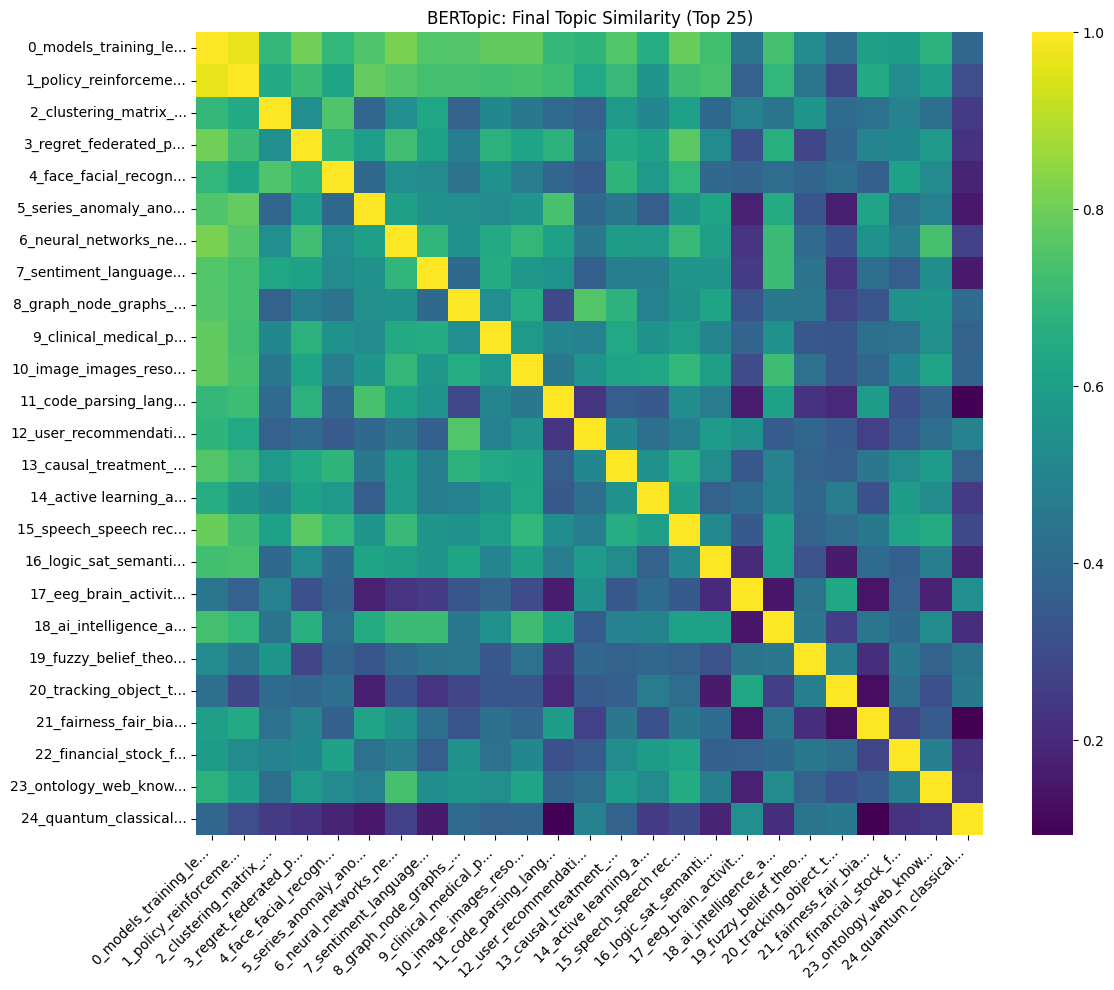

In [ ]:
# Cell 16: BERTopic - Visualizations (Optimized for Embedded HTML Display with Plotly Renderer Fix)

# --- Crucial imports for Plotly rendering and display ---
import plotly.io as pio
from IPython.display import HTML, display 

# --- Set the default Plotly renderer for Colab ---
# This is often the key to making Plotly figures display correctly inline.
pio.renderers.default = "colab"

# --- Other necessary imports for this cell ---
import matplotlib.pyplot as plt # For the seaborn heatmap
import seaborn as sns # For the seaborn heatmap
import numpy as np # For array operations
from sklearn.metrics.pairwise import cosine_similarity # For similarity heatmap

# --- Ensure necessary variables are loaded (model, documents, embeddings) ---
_model_ready_for_vis = False
if 'final_bertopic_model_to_visualize' in locals() and \
   hasattr(final_bertopic_model_to_visualize, 'get_topic_info') and \
   'documents_to_process' in locals() and \
   'active_embeddings_bertopic' in locals() and active_embeddings_bertopic is not None:
    _model_ready_for_vis = True
    # If the above check fails, the error message below will print.
else:
    print("ERROR: Final BERTopic model, documents, or embeddings not found. Visualizations cannot be generated.")
    print("Please ensure 'final_bertopic_model_to_visualize', 'documents_to_process', and 'active_embeddings_bertopic' are correctly defined from previous cells.")

if _model_ready_for_vis:
    df_final_vis_info = final_bertopic_model_to_visualize.get_topic_info()
    num_final_vis_topics = len(df_final_vis_info[df_final_vis_info.Topic != -1])

    # This outer check ensures we only try to visualize if there are actual topics.
    if num_final_vis_topics > 0:
        
        # --- 1. Intertopic Distance Map ---
        display(HTML("<h2>Intertopic Distance Map</h2>")) # Display title first
        try:
            fig_intertopic_bt = final_bertopic_model_to_visualize.visualize_topics(
                title="<b>BERTopic: Final Intertopic Distance Map</b>" # Title for the plot itself
            )
            # Generate HTML for the figure and display it
            html_intertopic = fig_intertopic_bt.to_html(full_html=False, include_plotlyjs='cdn')
            display(HTML(html_intertopic))
        except Exception as e:
            display(HTML(f"<p style='color:red;'>Error generating BERTopic Intertopic Distance Map: {e}</p>"))

        # --- 2. Topic Hierarchy ---
        display(HTML("<h2>Topic Hierarchy</h2>"))
        try:
            fig_hierarchy_bt = final_bertopic_model_to_visualize.visualize_hierarchy(
                title="<b>BERTopic: Final Topic Hierarchy</b>",
                top_n_topics=min(num_final_vis_topics, 50) 
            )
            html_hierarchy = fig_hierarchy_bt.to_html(full_html=False, include_plotlyjs='cdn')
            display(HTML(html_hierarchy))
        except ValueError: 
            display(HTML("<p><b>Topic Hierarchy:</b> Not generated (no strong hierarchical structure found or too few topics for this visualization).</p>"))
        except Exception as e:
            display(HTML(f"<p style='color:red;'>Error generating BERTopic Topic Hierarchy: {e}</p>"))

        # --- 3. Term Score Decline ---
        display(HTML("<h2>Term Score Decline per Topic</h2>"))
        try:
            fig_term_scores_bt = final_bertopic_model_to_visualize.visualize_term_rank(
                title="<b>BERTopic: Final Term Score Decline</b>"
            )
            html_term_scores = fig_term_scores_bt.to_html(full_html=False, include_plotlyjs='cdn')
            display(HTML(html_term_scores))
        except Exception as e:
            display(HTML(f"<p style='color:red;'>Error generating BERTopic Term Score Decline: {e}</p>"))

        # --- 4. Manual Topic Similarity Heatmap (Matplotlib/Seaborn) ---
        # This uses plt.show() and will appear as a static image.
        display(HTML("<h2>Topic Similarity Heatmap (Top N Topics)</h2>"))
        if hasattr(final_bertopic_model_to_visualize, 'topic_embeddings_') and \
           final_bertopic_model_to_visualize.topic_embeddings_ is not None:
            try:
                topic_embeddings_bt_final = final_bertopic_model_to_visualize.topic_embeddings_
                similarity_matrix_bt = cosine_similarity(topic_embeddings_bt_final)
                
                top_n_sim_plot = min(num_final_vis_topics, 25)
                actual_topic_ids_bt = sorted(list(df_final_vis_info[df_final_vis_info.Topic != -1].Topic.unique()))
                
                if top_n_sim_plot > len(actual_topic_ids_bt): # Ensure we don't try to plot more topics than exist
                    top_n_sim_plot = len(actual_topic_ids_bt)

                # Get embeddings and labels for the first top_n_sim_plot actual topics
                # Assuming topic_embeddings_ are ordered corresponding to sorted actual_topic_ids (0, 1, 2... if dense)
                # This needs careful indexing if topic IDs are sparse. For BERTopic, topic_embeddings_
                # are typically dense for topics 0 to N-1.
                selected_topic_indices_for_embedding = actual_topic_ids_bt[:top_n_sim_plot]

                # Ensure indices are valid for the similarity matrix shape
                if not selected_topic_indices_for_embedding or \
                   (selected_topic_indices_for_embedding and max(selected_topic_indices_for_embedding) >= similarity_matrix_bt.shape[0]):
                    # This case happens if topic IDs are sparse and higher than the number of rows in topic_embeddings_
                    # Fallback: use the first N rows/cols of the similarity matrix directly
                    print(f"Warning: Adjusting similarity plot to available embedding dimensions ({similarity_matrix_bt.shape[0]}).")
                    plot_limit = min(top_n_sim_plot, similarity_matrix_bt.shape[0])
                    sim_matrix_subset_bt = similarity_matrix_bt[:plot_limit, :plot_limit]
                    plot_labels_bt = [df_final_vis_info[df_final_vis_info.Topic == actual_topic_ids_bt[i]]["Name"].iloc[0][:20]+"..." 
                                      if i < len(actual_topic_ids_bt) and len(df_final_vis_info[df_final_vis_info.Topic == actual_topic_ids_bt[i]]["Name"].iloc[0]) > 20 
                                      else df_final_vis_info[df_final_vis_info.Topic == actual_topic_ids_bt[i]]["Name"].iloc[0] 
                                      if i < len(actual_topic_ids_bt) else f"T{i}" 
                                      for i in range(plot_limit)]

                else: # Ideal case: topic IDs align well with embedding indices
                    sim_matrix_subset_bt = similarity_matrix_bt[np.ix_(selected_topic_indices_for_embedding, selected_topic_indices_for_embedding)]
                    plot_labels_bt = []
                    for topic_id in selected_topic_indices_for_embedding:
                        try:
                            name = df_final_vis_info[df_final_vis_info.Topic == topic_id]["Name"].iloc[0]
                            short_name = name[:20] + "..." if len(name) > 20 else name
                            plot_labels_bt.append(short_name)
                        except (IndexError, KeyError):
                            plot_labels_bt.append(f"T{topic_id}") # Fallback to ID

                if sim_matrix_subset_bt.size > 0: # Proceed only if subset is not empty
                    plt.figure(figsize=(12, 10))
                    sns.heatmap(sim_matrix_subset_bt, annot=False, cmap="viridis", xticklabels=plot_labels_bt, yticklabels=plot_labels_bt)
                    plt.title(f"BERTopic: Final Topic Similarity (Top {len(plot_labels_bt)})")
                    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
                    plt.tight_layout()
                    plt.show() # This is Matplotlib's show(), it will render the static image.
                else:
                    display(HTML("<p><b>Topic Similarity Heatmap:</b> Could not generate subset for heatmap (check topic IDs and embeddings alignment).</p>"))

            except Exception as e:
                display(HTML(f"<p style='color:red;'>Error generating BERTopic similarity heatmap: {e}</p>"))
        else:
            display(HTML("<p><b>Topic Similarity Heatmap:</b> Topic embeddings not found in the model.</p>"))
    else:
        # This message will print if num_final_vis_topics is 0
        print("No actual topics found in the final BERTopic model to visualize.")

# The initial _model_ready_for_vis check handles the case where the model itself is not ready.

In [45]:
# calculate_topic_diversity

import numpy as np # Pastikan numpy diimport

def calculate_topic_diversity(topic_word_lists, top_n=10):
    """
    Calculates topic diversity as 1 - average Jaccard similarity between all pairs of topics.
    A higher score (closer to 1) indicates more diverse topics.
    """
    if not topic_word_lists or len(topic_word_lists) < 2:
        print("Warning: Less than two topics provided to calculate_topic_diversity. Returning 0.0 for diversity.")
        return 0.0 
    
    unique_topic_word_sets = []
    for topic_list in topic_word_lists:
        # Ensure topic_list is not empty and contains strings before creating a set
        if topic_list and all(isinstance(word, str) for word in topic_list):
            unique_topic_word_sets.append(set(topic_list[:top_n]))
        # else:
            # This case should ideally not happen if topic lists are well-formed
            # print(f"Debug: Found an empty or invalid topic list: {topic_list}")

    # If after filtering, we still have less than 2 valid sets, diversity is problematic
    if len(unique_topic_word_sets) < 2:
        print("Warning: Less than two valid topic word sets after filtering. Returning 0.0 for diversity.")
        return 0.0

    jaccard_scores = []
    for i in range(len(unique_topic_word_sets)):
        for j in range(i + 1, len(unique_topic_word_sets)):
            set1 = unique_topic_word_sets[i]
            set2 = unique_topic_word_sets[j]
            
            # Handle cases where sets might be empty if original lists were problematic
            if not set1 and not set2: # Both empty
                intersection = 0
                union = 0 # Avoid division by zero; Jaccard will be 1 if both empty (no diversity)
            elif not set1 or not set2: # One empty
                intersection = 0
                union = len(set1) + len(set2)
            else:
                intersection = len(set1.intersection(set2))
                union = len(set1.union(set2))
            
            if union == 0:
                jaccard_scores.append(1.0) # If both sets were empty, consider them identical (Jaccard = 1)
            else:
                jaccard_scores.append(intersection / union)
    
    if not jaccard_scores: # Should not happen if len(unique_topic_word_sets) >= 2
        print("Warning: No Jaccard scores calculated. Returning 0.0 for diversity.")
        return 0.0 # Or handle as an error, implies no pairs to compare
        
    # Topic diversity is 1 - average Jaccard similarity
    return 1.0 - np.mean(jaccard_scores)

print("Function 'calculate_topic_diversity' has been defined.")

Function 'calculate_topic_diversity' has been defined.


In [46]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [47]:
# Cell 17: Evaluation & Comparison (Auto-populated Summary)

import pandas as pd # Ensure pandas is imported
from IPython.display import display # For better DataFrame display in Colab
import numpy as np # For np.nan if values are missing

print("\n\n--- FINAL EVALUATION AND COMPARISON (AUTO-POPULATED) ---")

# --- Initialize dictionaries to hold values ---
lda_metrics = {
    "Optimal/Final # Topics": np.nan,
    "C_v Coherence": np.nan,
    "Topic Diversity (1-Avg Jaccard)": np.nan,
    "Outlier Percentage": "0% (assigns all docs)", # LDA specific
    "Primary Tuning Parameter(s)": "K (num_topics), alpha, eta, passes",
    "Preprocessing Intensity": "High (stopwords, lemmatization, dictionary filtering, phrasing)",
    "Interpretability (Subjective)": "Score: YOUR_LDA_RATING/5", # Placeholder for your rating
    "Key Strengths": "Well-established, good for keyword-based themes, pyLDAvis visualization",
    "Key Weaknesses/Challenges": "Sensitive to K & preprocessing, can mix broad concepts, no outlier detection"
}

bertopic_metrics = {
    "Optimal/Final # Topics": np.nan,
    "C_v Coherence": np.nan, # This will be the approximate C_v
    "Topic Diversity (1-Avg Jaccard)": np.nan,
    "Outlier Percentage": np.nan,
    "Primary Tuning Parameter(s)": "min_topic_size, embedding_model, (reduction/outlier params)",
    "Preprocessing Intensity": "Moderate (stopwords for vectorizer, embedding choice)",
    "Interpretability (Subjective)": "Score: YOUR_BERTOPIC_RATING/5", # Placeholder for your rating
    "Key Strengths": "Semantic understanding via embeddings, 'auto' topic discovery (initially), handles outliers, rich visualizations",
    "Key Weaknesses/Challenges": "Can have large general topic/many outliers initially, sensitive to min_topic_size & refinement steps, embedding time"
}

# --- 1. Populate LDA Model Metrics ---
if 'optimal_lda_model' in locals() and optimal_lda_model is not None:
    print("\nPopulating LDA Metrics...")
    if 'optimal_k_lda' in locals():
        lda_metrics["Optimal/Final # Topics"] = optimal_k_lda
    if 'highest_lda_coherence' in locals():
        lda_metrics["C_v Coherence"] = f"{highest_lda_coherence:.4f}"
    
    # Calculate LDA Topic Diversity (assuming calculate_topic_diversity function exists)
    if 'calculate_topic_diversity' in globals() and callable(calculate_topic_diversity):
        lda_topics_as_wordlists_eval_summary = []
        if hasattr(optimal_lda_model, 'num_topics'): # Check if model has num_topics
            for i in range(optimal_lda_model.num_topics):
                try:
                    words_scores = optimal_lda_model.show_topic(i, topn=15) # Get (word, prob)
                    lda_topics_as_wordlists_eval_summary.append([word for word, prob in words_scores])
                except Exception as e_lda_topic_words:
                    print(f"Warning: Could not get words for LDA topic {i}: {e_lda_topic_words}")
            if lda_topics_as_wordlists_eval_summary:
                lda_diversity_eval_summary = calculate_topic_diversity(lda_topics_as_wordlists_eval_summary)
                lda_metrics["Topic Diversity (1-Avg Jaccard)"] = f"{lda_diversity_eval_summary:.4f}"
            else:
                print("Warning: No LDA topic word lists generated for diversity calculation.")
        else:
            print("Warning: optimal_lda_model does not have num_topics attribute.")
    else:
        print("Warning: `calculate_topic_diversity` function not found for LDA diversity.")
    print("LDA Metrics populated.")
else:
    print("\nLDA model not fully available for populating metrics.")


# --- 2. Populate BERTopic Model Metrics ---
if 'final_bertopic_model_to_visualize' in locals() and \
   hasattr(final_bertopic_model_to_visualize, 'get_topic_info'):
    print("\nPopulating BERTopic Metrics...")
    df_final_bertopic_eval_info_summary = final_bertopic_model_to_visualize.get_topic_info()
    num_bertopic_final_eval_topics_summary = len(df_final_bertopic_eval_info_summary[df_final_bertopic_eval_info_summary.Topic != -1])
    bertopic_metrics["Optimal/Final # Topics"] = num_bertopic_final_eval_topics_summary
    
    outliers_final_bertopic_eval_series_summary = df_final_bertopic_eval_info_summary[df_final_bertopic_eval_info_summary.Topic == -1]['Count']
    outliers_final_bertopic_eval_summary = outliers_final_bertopic_eval_series_summary.iloc[0] if not outliers_final_bertopic_eval_series_summary.empty else 0
    
    total_docs_processed = len(documents_to_process) if 'documents_to_process' in locals() else SAMPLE_SIZE # Fallback to SAMPLE_SIZE if documents_to_process somehow missing
    if total_docs_processed > 0 :
      bertopic_metrics["Outlier Percentage"] = f"{(outliers_final_bertopic_eval_summary / total_docs_processed * 100):.1f}%"
    else:
      bertopic_metrics["Outlier Percentage"] = "N/A (total docs unknown)"


    bertopic_topics_as_wordlists_eval_summary = []
    if num_bertopic_final_eval_topics_summary > 0:
        for topic_id in df_final_bertopic_eval_info_summary[df_final_bertopic_eval_info_summary.Topic != -1].Topic:
            try:
                words_scores = final_bertopic_model_to_visualize.get_topic(topic_id)
                if words_scores:
                    bertopic_topics_as_wordlists_eval_summary.append([word for word, score in words_scores[:15]])
            except Exception as e_bt_topic_words:
                print(f"Warning: Could not get words for BERTopic topic {topic_id}: {e_bt_topic_words}")
    
    # Calculate C_v for BERTopic
    if bertopic_topics_as_wordlists_eval_summary and \
       'processed_docs_lda_phrased' in locals() and \
       'id2word_lda' in locals():
        try:
            coherence_model_bertopic_cv_eval_summary = CoherenceModel(
                topics=bertopic_topics_as_wordlists_eval_summary,
                texts=processed_docs_lda_phrased, # Use LDA's tokenized texts for comparability
                dictionary=id2word_lda,         # Use LDA's dictionary
                coherence='c_v'
            )
            bertopic_cv_coherence_eval_summary = coherence_model_bertopic_cv_eval_summary.get_coherence()
            bertopic_metrics["C_v Coherence"] = f"{bertopic_cv_coherence_eval_summary:.4f}"
        except Exception as e_bt_cv:
            print(f"Warning: Could not calculate BERTopic C_v coherence: {e_bt_cv}")
            bertopic_metrics["C_v Coherence"] = "Error/NA"
            
    # Calculate BERTopic Topic Diversity
    if bertopic_topics_as_wordlists_eval_summary and 'calculate_topic_diversity' in globals() and callable(calculate_topic_diversity):
        bertopic_diversity_eval_summary = calculate_topic_diversity(bertopic_topics_as_wordlists_eval_summary)
        bertopic_metrics["Topic Diversity (1-Avg Jaccard)"] = f"{bertopic_diversity_eval_summary:.4f}"
    elif not ('calculate_topic_diversity' in globals() and callable(calculate_topic_diversity)):
        print("Warning: `calculate_topic_diversity` function not found for BERTopic diversity.")
    else:
        print("Warning: No BERTopic topic word lists generated for diversity calculation.")
    print("BERTopic Metrics populated.")
else:
    print("\nFinal BERTopic model not fully available for populating metrics.")

# --- Create and Display Summary DataFrame ---
# Use the 'Metric/Aspect' from your image as the index
index_labels = [
    "Optimal/Final # Topics",
    "C_v Coherence",
    "Topic Diversity (1-Avg Jaccard)",
    "Outlier Percentage",
    "Primary Tuning Parameter(s)",
    "Preprocessing Intensity",
    "Interpretability (Subjective)",
    "Key Strengths",
    "Key Weaknesses/Challenges"
]

# Construct the DataFrame data by aligning metrics from lda_metrics and bertopic_metrics with index_labels
df_summary_data = {
    'Metric/Aspect': index_labels,
    'LDA': [lda_metrics.get(label, "N/A") for label in index_labels],
    'BERTopic': [bertopic_metrics.get(label, "N/A") for label in index_labels]
}

df_summary_final = pd.DataFrame(df_summary_data).set_index('Metric/Aspect')

print("\n--- Auto-Populated Illustrative Summary Table ---")
display(df_summary_final)


print("\n\n--- DISCUSSION POINTS FOR YOUR PAPER (Based on Auto-Populated Table & Previous Analysis) ---")
print("1. Qualitative Interpretability: Compare the meaningfulness and clarity of topics from LDA vs. BERTopic.")
print("   - Which model produced more intuitive or actionable themes for arXiv CS data? (Refer to your subjective ratings and topic keyword inspection)")
print("   - Did BERTopic's semantic approach offer advantages over LDA's keyword co-occurrence?")
print("2. Quantitative Metrics:")
print(f"   - LDA C_v: {lda_metrics.get('C_v Coherence', 'N/A')} vs. BERTopic Approx C_v: {bertopic_metrics.get('C_v Coherence', 'N/A')}. Discuss significance.")
print(f"   - LDA Diversity: {lda_metrics.get('Topic Diversity (1-Avg Jaccard)', 'N/A')} vs. BERTopic Diversity: {bertopic_metrics.get('Topic Diversity (1-Avg Jaccard)', 'N/A')}. Discuss.")
print("   - How do these quantitative scores align with your qualitative assessment?")
print("3. Outlier Handling:")
print(f"   - BERTopic Outlier Percentage: {bertopic_metrics.get('Outlier Percentage', 'N/A')}. Discuss its implications vs. LDA's 0% (by design).")
print("4. Computational Aspects & Ease of Use:")
print("   - Refer to your notes on time taken, preprocessing effort, hyperparameter tuning complexity.")
print("5. Visualizations:")
print("   - Which model's visualizations were more insightful (pyLDAvis vs. BERTopic's built-in plots)?")
print("6. Strengths & Weaknesses in Context of arXiv Data:")
print("   - Which model is better suited for exploring diverse scientific abstracts and why?")
print("7. Conclusion & Sinta 2 Justification:")
print("   - Based on all evidence, provide a justified conclusion on the comparison for your target journal.")



--- FINAL EVALUATION AND COMPARISON (AUTO-POPULATED) ---

Populating LDA Metrics...
LDA Metrics populated.

Populating BERTopic Metrics...
BERTopic Metrics populated.

--- Auto-Populated Illustrative Summary Table ---


,LDA,BERTopic
Metric/Aspect,,
Optimal/Final # Topics,28,29
C_v Coherence,0.4704,0.5627
Topic Diversity (1-Avg Jaccard),0.9657,0.9834
Outlier Percentage,0% (assigns all docs),34.5%
Primary Tuning Parameter(s),"K (num_topics), alpha, eta, passes","min_topic_size, embedding_model, (reduction/ou..."
Preprocessing Intensity,"High (stopwords, lemmatization, dictionary fil...","Moderate (stopwords for vectorizer, embedding ..."
Interpretability (Subjective),Score: YOUR_LDA_RATING/5,Score: YOUR_BERTOPIC_RATING/5
Key Strengths,"Well-established, good for keyword-based theme...","Semantic understanding via embeddings, 'auto' ..."
Key Weaknesses/Challenges,"Sensitive to K & preprocessing, can mix broad ...",Can have large general topic/many outliers ini...




--- DISCUSSION POINTS FOR YOUR PAPER (Based on Auto-Populated Table & Previous Analysis) ---
1. Qualitative Interpretability: Compare the meaningfulness and clarity of topics from LDA vs. BERTopic.
   - Which model produced more intuitive or actionable themes for arXiv CS data? (Refer to your subjective ratings and topic keyword inspection)
   - Did BERTopic's semantic approach offer advantages over LDA's keyword co-occurrence?
2. Quantitative Metrics:
   - LDA C_v: 0.4704 vs. BERTopic Approx C_v: 0.5627. Discuss significance.
   - LDA Diversity: 0.9657 vs. BERTopic Diversity: 0.9834. Discuss.
   - How do these quantitative scores align with your qualitative assessment?
3. Outlier Handling:
   - BERTopic Outlier Percentage: 34.5%. Discuss its implications vs. LDA's 0% (by design).
4. Computational Aspects & Ease of Use:
   - Refer to your notes on time taken, preprocessing effort, hyperparameter tuning complexity.
5. Visualizations:
   - Which model's visualizations were more insight